In [1]:
import os
import sys
import numpy as np
import xarray as xr
import cftime
import matplotlib.pyplot as plt


import cartopy.crs as ccrs
import cartopy
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams, cycler
from matplotlib import animation, rc
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import numpy as np
import xarray as xr
from xeofs.xarray import EOF
import rioxarray

import scipy
from scipy import signal
from shapely.geometry import mapping
from xarrayutils.utils import linear_trend, xr_linregress
import pandas as pd

In [75]:
ds = xr.open_dataset(inDirName+DIR_external+"MALI_projects/test_MALI_hist/relaxed_10yrs_4km_obs23.nc")

In [2]:
# FILE DIRECTORIES

# Define inDirName based on current working directories (relative paths to be constant across machines)
inDirName = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
#inDirName = "/storage/home/hcoda1/6/smurugan9/"
DIR_ISMIP6 = 'data/external/MALI_projects/ISMIP6_2300/'

In [3]:
# Base path to the processed input ismip6 ocean and smb forcing files.
# User has to supply.
forcing_basepath = "forcing/ais_mesh_4to20km_res/tier1_experiments/"
# Path to the initial condition file. User has to supply.
init_cond_path = "initial_conditions/AIS_4to20km_20230105/relaxation_0TGmelt_10yr/relaxed_10yrs_4km.nc"
# Path to the file for the basal melt parametrization coefficients.
melt_params_path = "initial_conditions/AIS_4to20km_20230105/basin_and_coeff_gamma0_DeltaT_quadratic_non_local_after_relaxation.nc"
# Path to the region mask file
region_mask_path = "initial_conditions/AIS_4to20km_20230105/AIS_4to20km_r01_20220907.regionMask_ismip6.nc"

In [4]:
init_cond = xr.open_dataset(inDirName+DIR_ISMIP6+init_cond_path)

In [15]:
inDirName+DIR_ISMIP6+init_cond_path

'/Users/smurugan9/research/aislens/aislens_emulation/data/external/MALI_projects/ISMIP6_2300/initial_conditions/AIS_4to20km_20230105/relaxation_0TGmelt_10yr/relaxed_10yrs_4km.nc'

In [74]:
# File path directories

inDirName = '/Users/smurugan9/research/aislens/aislens_emulation/'
DIR_external = 'data/external/'
DIR_interim = 'data/interim/'

# DATASET FILEPATHS
# Basal melt observations from Paolo 2023
DIR_basalMeltObs = 'data/external/Paolo2023/'
# Ocean model output - E3SM (SORRMv2.1.ISMF), data received from Darin Comeau / Matt Hoffman at LANL
DIR_SORRMv21 = 'data/external/SORRMv2.1.ISMF/regridded_output/'

# INTERIM GENERATED FILEPATHS
DIR_basalMeltObs_Interim = 'data/interim/Paolo2023/iceShelves_dedraft/'
DIR_SORRMv21_Interim = 'data/interim/SORRMv2.1.ISMF/iceShelves_dedraft/'

# DATA FILENAMES
FILE_basalMeltObs = 'ANT_G1920V01_IceShelfMelt.nc'
FILE_MeltDraftObs = 'ANT_G1920V01_IceShelfMeltDraft.nc'
FILE_SORRMv21 = 'Regridded_SORRMv2.1.ISMF.FULL.nc'


FILE_iceShelvesShape = 'iceShelves.geojson'

In [10]:
output_flux_2000 = xr.open_dataset("/Users/smurugan9/research/aislens/MALI-ismip6-0721/ntasks72-n16/landice/ismip6_run/ismip6_ais_proj2300/hist_04/output/yearly/output_flux_all_timesteps_2000.nc")

In [16]:
init_cond_mpasgrid = xr.open_dataset("/Users/smurugan9/research/aislens/aislens_emulation/data/external/MALI_projects/init_cond/init_cond_4km.nc")

In [21]:
init_cond_mpasgrid.ismip6shelfMelt_offset

<xarray.DataArray 'ismip6shelfMelt_offset' (nCells: 385379)>
array([nan, nan, nan, ..., nan, nan, nan])
Dimensions without coordinates: nCells
Attributes:
    units:      kg m^{-2} s^{-1}
    long_name:  Optional field of offset that should be applied to the melt f...

In [47]:
init_cond

<xarray.Dataset>
Dimensions:                          (nEdges: 1161656, nCells: 385379,
                                      nVertices: 776277, Time: 1, maxEdges: 9,
                                      TWO: 2, vertexDegree: 3,
                                      nVertInterfaces: 6, maxEdges2: 18,
                                      nISMIP6OceanLayers: 30, nVertLevels: 5)
Dimensions without coordinates: nEdges, nCells, nVertices, Time, maxEdges, TWO,
                                vertexDegree, nVertInterfaces, maxEdges2,
                                nISMIP6OceanLayers, nVertLevels
Data variables: (12/59)
    angleEdge                        (nEdges) float64 ...
    areaCell                         (nCells) float64 ...
    areaTriangle                     (nVertices) float64 ...
    basalHeatFlux                    (Time, nCells) float64 ...
    bedTopography                    (Time, nCells) float64 ...
    cellsOnCell                      (nCells, maxEdges) int32 ...
    ...                               ...
    yCell                            (nCells) float64 ...
    yEdge                            (nEdges) float64 ...
    yVertex                          (nVertices) float64 ...
    zCell                            (nCells) float64 ...
    zEdge                            (nEdges) float64 ...
    zVertex                          (nVertices) float64 ...
Attributes: (12/183)
    model_name:                                             mpas
    core_name:                                              landice
    source:                                                 MPAS
    Conventions:                                            MPAS
    git_version:                                            v2.1.0-alpha.1-22...
    on_a_sphere:                                            NO
    ...                                                     ...
    config_AM_regionalStats_compute_interval:               output_interval
    config_AM_regionalStats_stream_name:                    regionalStatsOutput
    config_AM_regionalStats_compute_on_startup:             YES
    config_AM_regionalStats_write_on_startup:               YES
    file_id:                                                jzt8a2gxaf
    NCO:                                                    netCDF Operators ...

In [24]:
obs_interp_mean = xr.open_dataset(inDirName+DIR_basalMeltObs+"obs_interp_mean.nc")

In [25]:
obs_interp_mean_flux = obs_interp_mean*910.0/(3600.0*24.0*365.0)

In [44]:
crs = ccrs.SouthPolarStereo();

In [33]:
vmin = np.nanquantile(obs_interp_mean_flux.subm[:], 0.01)
vmax = np.nanquantile(obs_interp_mean_flux.subm[:], 0.99)

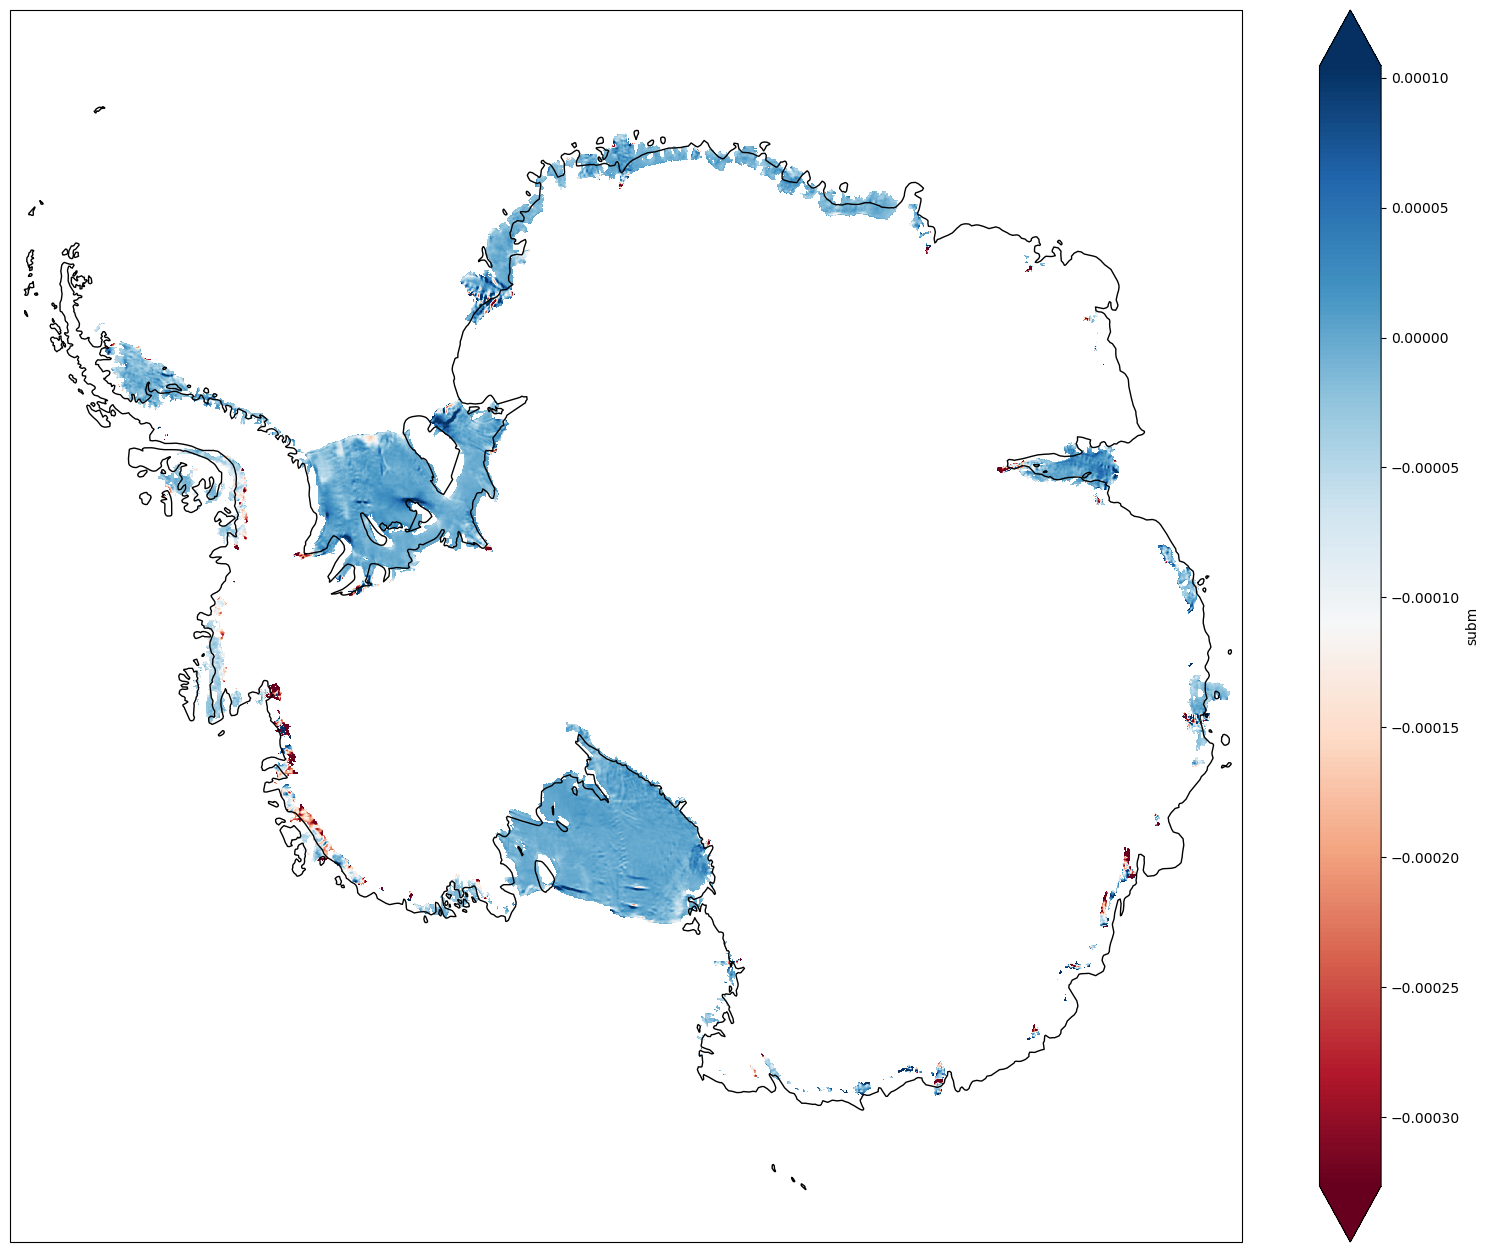

In [49]:
fig, ax = plt.subplots(figsize=(20,16),subplot_kw=dict(projection=crs))
obs_interp_mean_flux.subm.plot(ax=ax, vmin=vmin, vmax=vmax, cmap="RdBu")
ax.coastlines()

In [7]:
obs_interp = xr.open_dataset(inDirName+DIR_basalMeltObs+"obs_interp.nc")

In [50]:
globalStats = xr.open_dataset(inDirName+DIR_external+"MALI_projects/test_MALI_hist/globalStats.nc")
regionalStats = xr.open_dataset(inDirName+DIR_external+"MALI_projects/test_MALI_hist/regionalStats.nc")

In [64]:
obs23 = init_cond.ismip6shelfMelt_offset

In [65]:
init_cond["floatingBasalMassBal"] = obs23

In [69]:
init_cond.to_netcdf(inDirName+DIR_external+"MALI_projects/test_MALI_hist/relaxed_10yrs_4km_obs23.nc")

In [71]:
inDirName+DIR_external+"MALI_projects/test_MALI_hist"

'/Users/smurugan9/research/aislens/aislens_emulation/data/external/MALI_projects/test_MALI_hist'